In [2]:
%matplotlib inline

In [3]:
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import dgl
from dgl.data import CoraGraphDataset
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
from torch.utils.tensorboard import SummaryWriter

def load_cora_data():
    dataset = CoraGraphDataset()
    num_classes = dataset.num_classes
    g = dataset[0]
    scaler = MinMaxScaler()
    features = torch.tensor(scaler.fit_transform(g.ndata["feat"]), dtype=torch.float)
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"]
    test_mask = g.ndata["test_mask"]
    return g, features, labels, num_classes, train_mask, test_mask


#g, features, labels, num_classes, train_mask, test_mask = load_cora_data()

Generated Graph:
Graph(num_nodes=40, num_edges=50,
      ndata_schemes={'feat': Scheme(shape=(5,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})


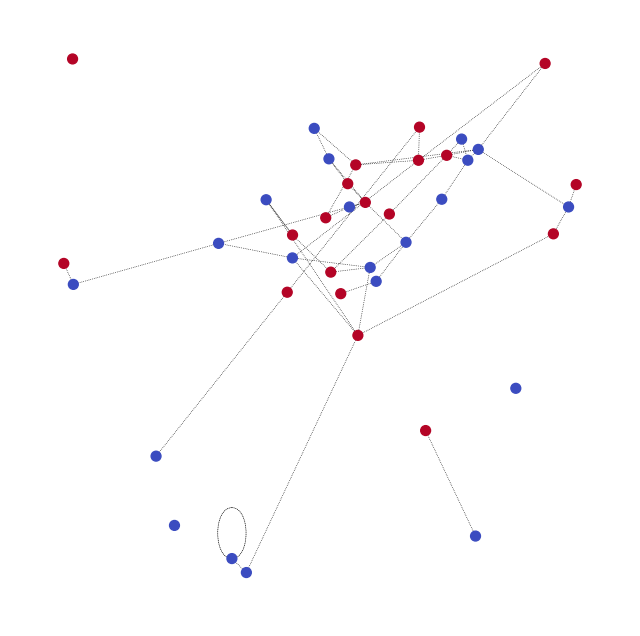

In [4]:
# Define the number of nodes, edges, and feature dimensions
num_nodes = 40
num_edges = 50
feat_dim = 5

torch.manual_seed(222)
edges = torch.randint(num_nodes, size=(2, num_edges))
g = dgl.graph((edges[0], edges[1]), num_nodes=num_nodes)

# Assign random features to the nodes
features = torch.randn(num_nodes, feat_dim)
labels = torch.randint(2, size=(num_nodes,))

# Set the node features in the graph
g.ndata['feat'] = features
g.ndata['label'] = labels

# Print the generated graph
print("Generated Graph:")
print(g)
#print("\nNode Features:")
#print(g.ndata['feat'])
#print(g.ndata['label'])


inc = g.inc('both')

nxGraph = g.to_networkx()

def visualize(labels, g):
    pos = nx.spring_layout(g, seed=1)
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    nx.draw_networkx(g, pos=pos, node_size=50, cmap=plt.get_cmap('coolwarm'),
                     node_color=labels, edge_color='k',
                     arrows=False, width=0.5, style='dotted', with_labels=False)
visualize(labels, nxGraph)



In [5]:
from dgl.nn import GraphConv

class LGNNCore(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(LGNNCore, self).__init__()
        #self.linear_prev = nn.Linear(in_feats, out_feats)
        self.conv = GraphConv(in_feats, out_feats)
        self.linear_fuse = nn.Linear(in_feats, out_feats)

    def forward(self, g, feat_a, feat_b, pm_pd):
        g = dgl.add_self_loop(g)
        conv_layer = F.relu(self.conv(g, feat_a))
        fuse = self.linear_fuse(torch.mm(pm_pd, feat_b))
        # sum them together
        result = conv_layer + fuse
        result = F.relu(result)

        return result

In [6]:
class LGNNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(LGNNLayer, self).__init__()
        self.g_layer = LGNNCore(in_feats, out_feats)
        self.lg_layer = LGNNCore(in_feats, out_feats)

    def forward(self, g, lg, x, lg_x, inc):
        next_x = self.g_layer(g, x, lg_x, inc)
        inc_y = torch.transpose(inc, 0, 1)
        next_lg_x = self.lg_layer(lg, lg_x, x, inc_y)
        return next_x, next_lg_x

In [7]:
class LGNN(nn.Module):
    def __init__(self):
        super(LGNN, self).__init__()
        self.layer1 = LGNNLayer(5, 16)  # input is scalar feature
        self.layer2 = LGNNLayer(16, 16)  # hidden size is 16
        self.layer3 = LGNNLayer(16, 16)
        self.linear = nn.Linear(16, 2)  # predice two classes

    def forward(self, g, lg, inc):
        # use degree as the input feature
        x = g.ndata['feat']
        lg_x = lg.ndata['feat']

        x, lg_x = self.layer1(g, lg, x, lg_x, inc)
        x, lg_x = self.layer2(g, lg, x, lg_x, inc)
        x, lg_x = self.layer3(g, lg, x, lg_x, inc)
        return F.relu(self.linear(x))

Training and inference
-----------------------
First load the data.



In [8]:
model = LGNN()
#print(model)

MODEL_NAME = 'Testing2'
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
writer = SummaryWriter()


# A utility function to convert a scipy.coo_matrix to torch.SparseFloat
def sparse2th(mat):
    value = mat.data
    indices = torch.LongTensor([mat.row, mat.col])
    tensor = torch.sparse.FloatTensor(indices, torch.from_numpy(value).float(), mat.shape)
    return tensor

# Train for 20 epochs
for i in range(200):
    
    lg = g.line_graph(backtracking=False)
    lg.ndata['feat'] = torch.zeros(lg.num_nodes(),5)

    optimizer.zero_grad()

    # Forward
    z = model(g, lg, inc)
    # Since there are only two communities, there are only two permutations    #  of the community labels.
    loss_perm1 = F.cross_entropy(z, labels)
    loss_perm2 = F.cross_entropy(z, 1 - labels)
    loss = torch.min(loss_perm1, loss_perm2)
    # Calculate accuracy:
    _, pred = torch.max(z, 1)
    acc_perm1 = (pred == labels).float().mean()
    acc_perm2 = (pred == 1 - labels).float().mean()
    acc = torch.max(acc_perm1, acc_perm2)

    loss.backward()
    optimizer.step()

    print("Epoch %d | loss %.4f | accuracy %.4f" % (i, loss, acc))
    writer.add_scalar("Loss/train", loss, i)
    writer.add_scalar("Accuarcy/train", acc, i)
    
writer.flush()
writer.close()

Epoch 0 | loss 0.6881 | accuracy 0.5250
Epoch 1 | loss 0.6848 | accuracy 0.5250
Epoch 2 | loss 0.6786 | accuracy 0.5250
Epoch 3 | loss 0.6684 | accuracy 0.5250
Epoch 4 | loss 0.6603 | accuracy 0.5250
Epoch 5 | loss 0.6514 | accuracy 0.5250
Epoch 6 | loss 0.6403 | accuracy 0.5250
Epoch 7 | loss 0.6293 | accuracy 0.5250
Epoch 8 | loss 0.6188 | accuracy 0.5250
Epoch 9 | loss 0.6091 | accuracy 0.5250
Epoch 10 | loss 0.6000 | accuracy 0.5250
Epoch 11 | loss 0.5922 | accuracy 0.5250
Epoch 12 | loss 0.5851 | accuracy 0.5250
Epoch 13 | loss 0.5789 | accuracy 0.5250
Epoch 14 | loss 0.5725 | accuracy 0.5250
Epoch 15 | loss 0.5667 | accuracy 0.5250
Epoch 16 | loss 0.5607 | accuracy 0.5250
Epoch 17 | loss 0.5554 | accuracy 0.5250
Epoch 18 | loss 0.5474 | accuracy 0.5250
Epoch 19 | loss 0.5392 | accuracy 0.5250
Epoch 20 | loss 0.5327 | accuracy 0.5250
Epoch 21 | loss 0.5281 | accuracy 0.5250
Epoch 22 | loss 0.5239 | accuracy 0.5250
Epoch 23 | loss 0.5168 | accuracy 0.5250
Epoch 24 | loss 0.5139 | a

Visualize training progress
-----------------------------
You can visualize the network's community prediction on one training example,
together with the ground truth. Start this with the following code example.



In [9]:
'''pmpd1 = sparse2th(pmpd1)
LG1 = G1.line_graph(backtracking=False)
z = model(G1, LG1, pmpd1)
_, pred = torch.max(z, 1)
visualize(pred, nx_G1)'''

'pmpd1 = sparse2th(pmpd1)\nLG1 = G1.line_graph(backtracking=False)\nz = model(G1, LG1, pmpd1)\n_, pred = torch.max(z, 1)\nvisualize(pred, nx_G1)'

Compared with the ground truth. Note that the color might be reversed for the
two communities because the model is for correctly predicting the partitioning.



Here is an animation to better understand the process. (40 epochs)

.. figure:: https://i.imgur.com/KDUyE1S.gif 
   :alt: lgnn-anim

Batching graphs for parallelism
--------------------------------

LGNN takes a collection of different graphs.
You might consider whether batching can be used for parallelism.

Batching has been into the data loader itself.
In the ``collate_fn`` for PyTorch data loader, graphs are batched using DGL's
batched_graph API. DGL batches graphs by merging them
into a large graph, with each smaller graph's adjacency matrix being a block
along the diagonal of the large graph's adjacency matrix.  Concatenate
:math`\{Pm,Pd\}` as block diagonal matrix in correspondence to DGL batched
graph API.



In [10]:
'''def collate_fn(batch):
    graphs, pmpds, labels = zip(*batch)
    batched_graphs = dgl.batch(graphs)
    batched_pmpds = sp.block_diag(pmpds)
    batched_labels = np.concatenate(labels, axis=0)
    return batched_graphs, batched_pmpds, batched_labels'''

'def collate_fn(batch):\n    graphs, pmpds, labels = zip(*batch)\n    batched_graphs = dgl.batch(graphs)\n    batched_pmpds = sp.block_diag(pmpds)\n    batched_labels = np.concatenate(labels, axis=0)\n    return batched_graphs, batched_pmpds, batched_labels'

You can find the complete code on Github at 
`Community Detection with Graph Neural Networks (CDGNN) <https://github.com/dmlc/dgl/tree/master/examples/pytorch/line_graph>`_.

